<a href="https://colab.research.google.com/github/Scorsess/RelationNetworks-CLEVR/blob/master/VQA_CLEVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model interpretation for Visual Question Answering

In [1]:
## Install the libraries
!pip install torchvision pillow matplotlib captum pdbpp wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 33.7 MB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 
  Created wheel for pyrepl: filename=pyrepl-0.9.0-py3-none-any.whl size=59907 sha256=0a87a6464a6350b822316dad5e922babf397e18fc50f5f0870a075688b1faf88
  Stored in directory: /root/.cache/pip/wheels/3c/d7/37/7503eea89bb7987b7553bd90528a3554e3be0dd90b095c782c
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f406b498a2d43868f9b96926939968a873e9e237b1ce802b147391787a0c3644
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
  Created wheel for wmctrl: filename=wmctrl-0.4-py3-none-any.whl size=3857 sha256=3ff3f763f14d221d9f84455bb22b57f7a45b0ad7878c8f3ca7f9549773023dae
  Stored in directory: /root/.cache/pip/wheels/34/41/26/7eb2a9e48d9024b4607b7f684c55c9ce3a662e17b7a8b50e67
Successfully built pyrepl 

In [2]:
## Clone Git repos

!git clone https://github.com/Scorsess/pytorch-vqa
!git clone https://github.com/Scorsess/pytorch-resnet

Cloning into 'pytorch-vqa'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 107 (delta 40), reused 62 (delta 38), pack-reused 40
Receiving objects: 100% (107/107), 2.28 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Cloning into 'pytorch-resnet'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [3]:
import os, sys

# Replace <PROJECT-DIR> placeholder with your project directory path
PROJECT_DIR = '/content'

# Clone PyTorch VQA project from: https://github.com/Scorsess/pytorch-vqa and add to your filepath
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/pytorch-vqa"))

# Clone PyTorch Resnet model from: https://github.com/Scorsess/pytorch-resnet and add to your filepath
# We can also use standard resnet model from torchvision package, however the model from `pytorch-resnet` 
# is slightly different from the original resnet model and performs better on this particular VQA task
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/pytorch-resnet"))

In [5]:
import threading
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import resnet  # from pytorch-resnet

import pdb

import wget

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

from model import Net, apply_attention, tile_2d_over_nd # from pytorch-vqa
from utils import get_transform # from pytorch-vqa

from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    GradientShap,
    Occlusion,
    NoiseTunnel,
    TokenReferenceBase,
    configure_interpretable_embedding_layer,
    remove_interpretable_embedding_layer,
    visualization
)
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#a=torch.load('https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth')

# Loading VQA model 

### VQA model can be downloaded from: 
### https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [7]:
wget.download('https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth')

'2017-08-04_00.55.19.pth'

In [ ]:
wget.download('https://cs.stanford.edu/people/jcjohns/clevr/teaser.jpg')

'teaser.jpg'

In [8]:
saved_state = torch.load('pytorch-vqa/models/2017-08-04_00.55.19.pth', map_location=device)

# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

In [9]:
# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

In [10]:
# Loads predefined VQA model and sets it to eval mode.
# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`

vqa_net = torch.nn.DataParallel(Net(num_tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

/content/pytorch-vqa/model.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/pytorch-vqa/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

In [11]:
# Converting string question into a tensor. `encode_question` function is similar to original implementation of `encode_question` method in pytorch-vqa source code.
# https://github.com/Cyanogenoid/pytorch-vqa/blob/master/data.py#L110

def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [12]:
# # Defining end-to-end VQA model

# Original saved model does not have image network's (resnet's) layers attached to it. We attach it in the below cell using forward-hook. The rest of the model is identical to the original definition of the model: https://github.com/Cyanogenoid/pytorch-vqa/blob/master/model.py#L48


class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True)
        self.r_model.eval()
        self.r_model.to(device)

        self.buffer = {}
        lock = threading.Lock()

        # Since we only use the output of the 4th layer from the resnet model and do not
        # need to do forward pass all the way to the final layer we can terminate forward
        # execution in the forward hook of that layer after obtaining the output of it.
        # For that reason, we can define a custom Exception class that will be used for
        # raising early termination error.
        def save_output(module, input, output):
            with lock:
                self.buffer[output.device] = output

        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.r_model(x)          
        return self.buffer[x.device]

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()
    
    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = self.resnet_layer4(v)

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer

In [13]:
# In order to explain text features, we must let integrated gradients attribute on the embeddings, not the indices. The reason for this is simply due to Integrated Gradients being a gradient-based attribution method, as we are unable to compute gradients with respect to integers.
# 
# Hence, we have two options:
# 1. "Patch" the model's embedding layer and corresponding inputs. To patch the layer, use the `configure_interpretable_embedding_layer`^ method, which will wrap the associated layer you give it, with an identity function. This identity function accepts an embedding and outputs an embedding. You can patch the inputs, i.e. obtain the embedding for a set of indices, with `model.wrapped_layer.indices_to_embeddings(indices)`.
# 2. Use the equivalent layer attribution algorithm (`LayerIntegratedGradients` in our case) with the utility class `ModelInputWrapper`. The `ModelInputWrapper` will wrap your model and feed all it's inputs to seperate layers; allowing you to use layer attribution methods on inputs. You can access the associated layer for input named `"foo"` via the `ModuleDict`: `wrapped_model.input_maps["foo"]`.
# 
# ^ NOTE: For option (1), after finishing interpretation it is important to call `remove_interpretable_embedding_layer` which removes the Interpretable Embedding Layer that we added for interpretation purposes and sets the original embedding layer back in the model.
# 
# Below I am using the `USE_INTEPRETABLE_EMBEDDING_LAYER` flag to do option (1) if it is True, otherwise (2) if it is False. Generally it is reccomended to do option (2) since this option is much more flexible and easy to use. The reason it is more flexible is it allows your model to do any sort of preprocessing to the indices tensor. It's easier to use since you don't have to touch your inputs.

USE_INTEPRETABLE_EMBEDDING_LAYER = False  # set to True for option (1)

In [14]:
# Updating weights from the saved model and removing the old model from the memory. And wrap the model with `ModelInputWrapper`.

vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)

# wrap the inputs into layers incase we wish to use a layer method
vqa_resnet = ModelInputWrapper(vqa_resnet)

# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet)

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.module.state_dict()
state.update(partial_dict)
vqa_resnet.module.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [15]:
# Patch the model's embedding layer if we're doing option (1)

if USE_INTEPRETABLE_EMBEDDING_LAYER:
    interpretable_embedding = configure_interpretable_embedding_layer(vqa_resnet, 'module.module.text.embedding')

In [16]:
# Below function will help us to transform and image into a tensor.

image_size = 448  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
    
def image_to_features(img):
    img_transformed = transform(img)
    img_batch = img_transformed.unsqueeze(0).to(device)
    return img_batch

In [17]:
# Creating reference aka baseline / background for questions. This is specifically necessary for baseline-based model interpretability algorithms. In this case for integrated gradients. More details can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

PAD_IND = token_to_index['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [18]:
# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled=False

In [19]:
# Creating an instance of layer integrated gradients for option (2); otherwise create an instance of integrated gradients for option (1). Both are equivalent methods to interpret the model's outputs.

if USE_INTEPRETABLE_EMBEDDING_LAYER:
    #attr = IntegratedGradients(vqa_resnet)
    attr = GradientShap(vqa_resnet)
else:
    attr = LayerIntegratedGradients(vqa_resnet, [vqa_resnet.module.input_maps["v"], vqa_resnet.module.module.text.embedding])

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/layer/layer_integrated_gradients.py:103: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  "Multiple layers provided. Please ensure that each layer is"


In [20]:
# Defining default cmap that will be used for image visualizations 

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)

In [21]:
# Defining a few test images for model intepretation purposes

images = ['pytorch-vqa/img/CLEVR_unique_000000.png',
          'pytorch-vqa/img/CLEVR_unique_000001.png',
          'pytorch-vqa/img/CLEVR_unique_000002.png',
          'pytorch-vqa/img/CLEVR_unique_000003.png',
          'pytorch-vqa/img/CLEVR_unique_000004.png',
          'pytorch-vqa/img/CLEVR_unique_000005.png',
          'pytorch-vqa/img/CLEVR_unique_000006.png',
          'pytorch-vqa/img/CLEVR_unique_000007.png',
          'pytorch-vqa/img/CLEVR_unique_000008.png',
          'pytorch-vqa/img/CLEVR_unique_000009.png',
          'pytorch-vqa/img/CLEVR_unique_0000010.png']

In [26]:
gt_masks = ['pytorch-vqa/img/0.npy',
            'pytorch-vqa/img/1.npy',
            'pytorch-vqa/img/2.npy',
            'pytorch-vqa/img/3.npy',
            'pytorch-vqa/img/4.npy',
            'pytorch-vqa/img/5.npy',
            'pytorch-vqa/img/6.npy',
            'pytorch-vqa/img/7.npy',
            'pytorch-vqa/img/8.npy',
            'pytorch-vqa/img/9.npy',
            'pytorch-vqa/img/10.npy',
            'pytorch-vqa/img/11.npy',
            'pytorch-vqa/img/12.npy',
            'pytorch-vqa/img/13.npy',
            'pytorch-vqa/img/14.npy',
            'pytorch-vqa/img/15.npy',
            'pytorch-vqa/img/16.npy',
            'pytorch-vqa/img/17.npy']

In [41]:
def vqa_resnet_interpret(image_filename, questions, targets):
    img = Image.open(image_filename).convert('RGB')
    original_image = transforms.Compose([transforms.Resize(int(image_size / central_fraction)),
                                   transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    
    image_features = image_to_features(img).requires_grad_().to(device)
    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)
        
        # generate reference for each sample
        q_reference_indices = token_reference.generate_reference(q_len.item(), device=device).unsqueeze(0)

        inputs = (q.unsqueeze(0), q_len.unsqueeze(0))
        if USE_INTEPRETABLE_EMBEDDING_LAYER:
            q_input_embedding = interpretable_embedding.indices_to_embeddings(q).unsqueeze(0)
            q_reference_baseline = interpretable_embedding.indices_to_embeddings(q_reference_indices).to(device)

            inputs = (image_features, q_input_embedding)
            baselines = (image_features * 0.0, q_reference_baseline)
            
        else:            
            inputs = (image_features, q.unsqueeze(0))
            baselines = (image_features * 0.0, q_reference_indices)
            
        ans = vqa_resnet(*inputs, q_len.unsqueeze(0))
            
        # Make a prediction. The output of this prediction will be visualized later.
        pred, answer_idx = F.softmax(ans, dim=1).data.cpu().max(dim=1)

        attributions = attr.attribute(inputs=inputs,
                                    baselines=baselines,
                                    target=answer_idx,
                                    additional_forward_args=q_len.unsqueeze(0),
                                    n_steps=15)
            
        # Visualize text attributions
        text_attributions_norm = attributions[1].sum(dim=2).squeeze(0).norm()
        vis_data_records = [visualization.VisualizationDataRecord(
                                attributions[1].sum(dim=2).squeeze(0) / text_attributions_norm,
                                pred[0].item(),
                                answer_words[ answer_idx ],
                                answer_words[ answer_idx ],
                                target,
                                attributions[1].sum(),       
                                question.split(),
                                0.0)]
        visualization.visualize_text(vis_data_records)

        # visualize image attributions
        original_im_mat = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
        attributions_img = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
        
        visualization.visualize_image_attr_multiple(attributions_img, original_im_mat, 
                                                    ["original_image", "heat_map"], ["all", "all"], 
                                                    titles=["Original Image", "Attribution Magnitude"],
                                                    #cmap=default_cmap,
                                                    cmap='seismic',
                                                    show_colorbar=True)
        img_array = np.load(gt_masks[0])
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
        axes[0].imshow(attributions_img * 224)
        axes[1].imshow(original_im_mat)
        axes[2].imshow(img_array,  cmap='gray')
        plt.show()

        print('Text Contributions: ', attributions[1].sum().item())
        print('Image Contributions: ', attributions[0].sum().item())
        print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
fruit,fruit (0.11),objects,3.39,what is on the picture


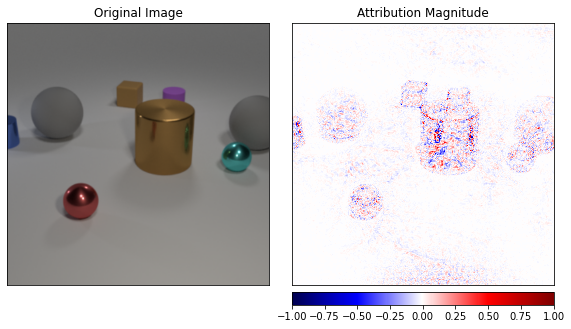

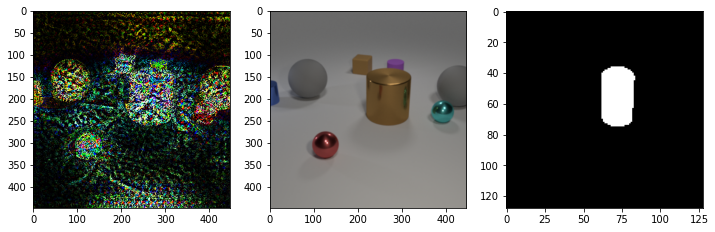

Text Contributions:  3.393250680887684
Image Contributions:  13.448100091426426
Total Contribution:  16.841350772314108


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,3 (0.18),3,25.68,How many round objects are on the image


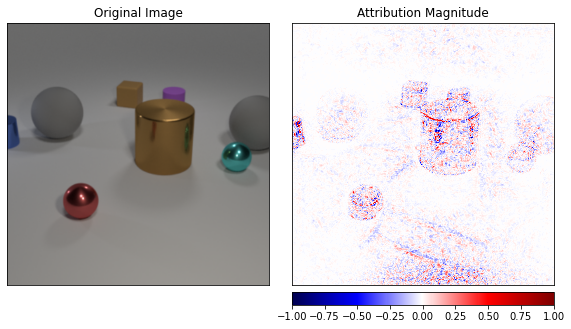

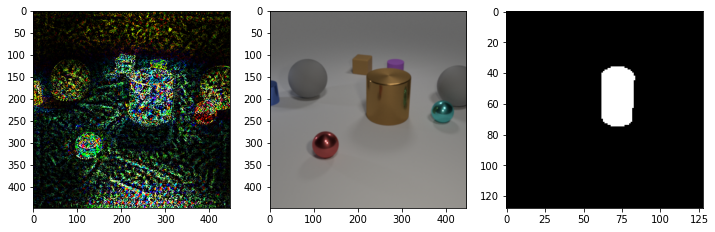

Text Contributions:  25.677657081783693
Image Contributions:  10.728277448794715
Total Contribution:  36.405934530578406


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
on wall,on wall (0.08),on the left,16.16,where is the red cube


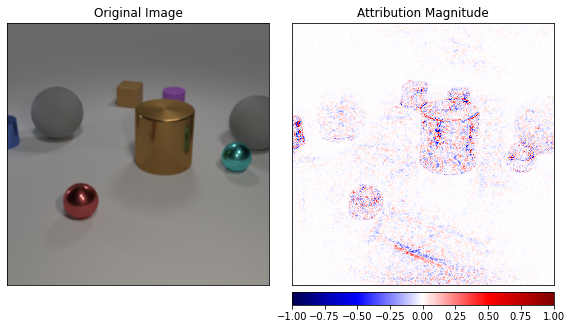

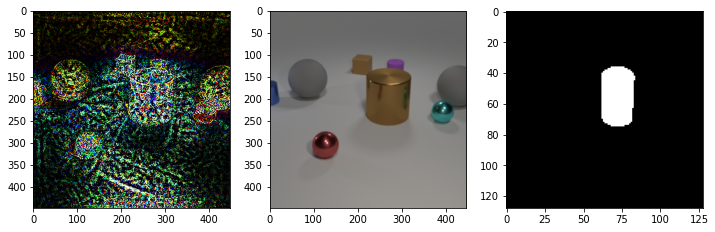

Text Contributions:  16.160931412817128
Image Contributions:  11.260242657914716
Total Contribution:  27.421174070731844


In [42]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 0 # Test image 1
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "How many round objects are on the image",
    "where is the red cube"
], ['objects', '3', 'on the left'])

In [27]:
img_array = np.load(gt_masks[0])

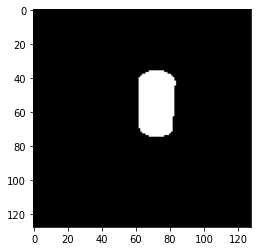

In [28]:
plt.imshow(img_array, cmap='gray')
plt.show()

NameError: ignored

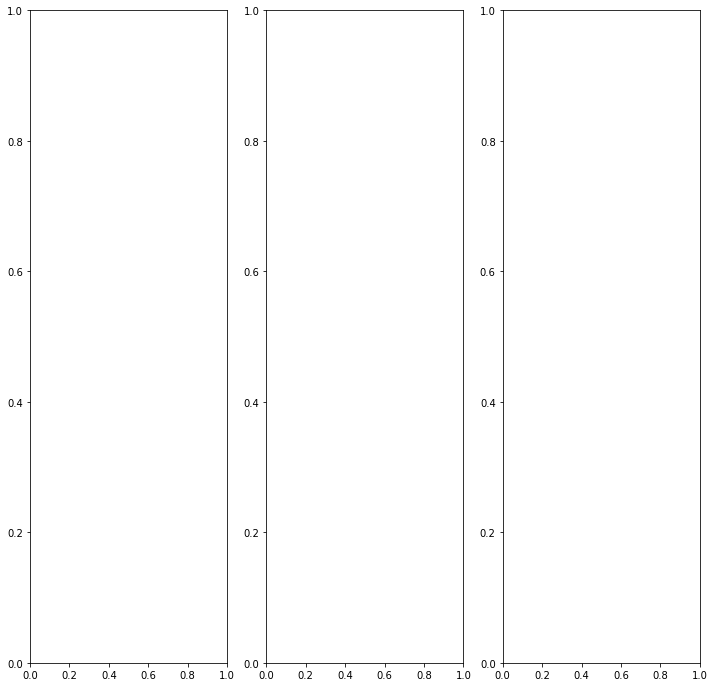

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
axes[0] = attributions_img
axes[1] = original_im_mat

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
elephant,elephant (0.73),elephant,10.24,what is on the picture


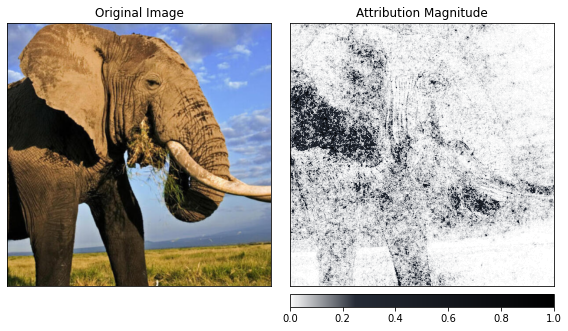

Text Contributions:  10.238883667343442
Image Contributions:  16.26616959412339
Total Contribution:  26.505053261466834


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
gray,gray (0.76),gray,8.49,what color is the elephant


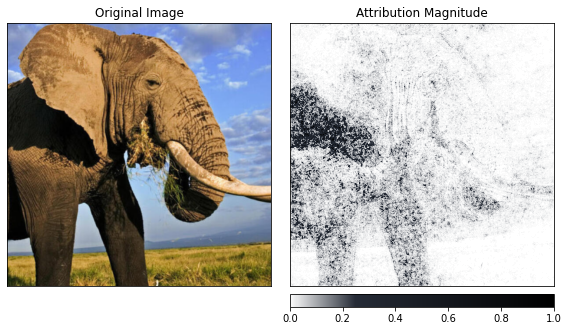

Text Contributions:  8.491674828172915
Image Contributions:  9.847278709345446
Total Contribution:  18.33895353751836


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
in grass,in grass (0.16),zoo,21.57,where is the elephant


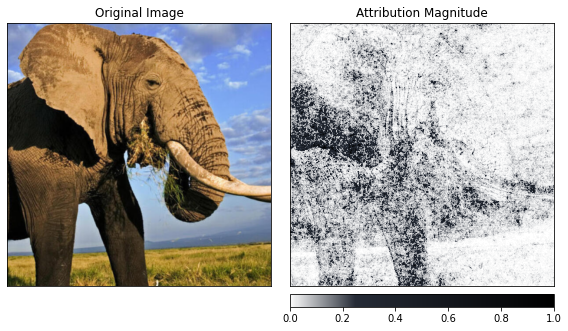

Text Contributions:  21.572867637705468
Image Contributions:  10.443005059553897
Total Contribution:  32.01587269725937


In [ ]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 1 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is the elephant",
    "where is the elephant"
], ['elephant', 'gray', 'zoo'])

In [ ]:
import IPython
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/elephant_attribution.jpg')

In [ ]:
image_idx = 0 # cat

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the cat's eyes",
    "is the animal in the picture a cat or a fox",
    "what color is the cat",
    "how many ears does the cat have",
    "where is the cat"
], ['cat', 'blue', 'cat', 'white and brown', '2', 'at the wall'])

In [ ]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/siamese_attribution.jpg')

In [ ]:
image_idx = 2 # zebra

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the zebras",
    "how many zebras are on the picture",
    "where are the zebras"
], ['zebra', 'black and white', '2', 'zoo'])

In [ ]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/zebra_attribution.jpg')

In [ ]:
# As mentioned above, after we are done with interpretation, we have to remove Interpretable Embedding Layer and set the original embeddings layer back to the model.

if USE_INTEPRETABLE_EMBEDDING_LAYER:
    remove_interpretable_embedding_layer(vqa_resnet, interpretable_embedding)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
fruit,fruit (0.16),objects,2.40,what is on the picture


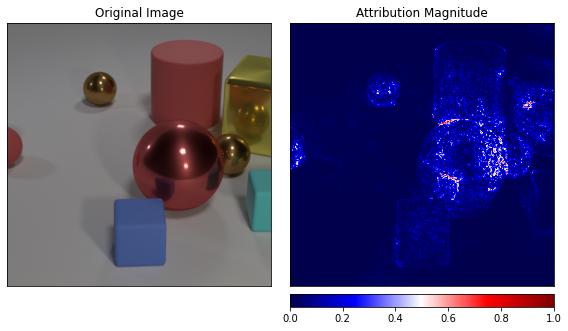

Text Contributions:  2.396767237837765
Image Contributions:  9.331815850014102
Total Contribution:  11.728583087851867


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
red,red (0.46),red,12.65,what color is large sphere


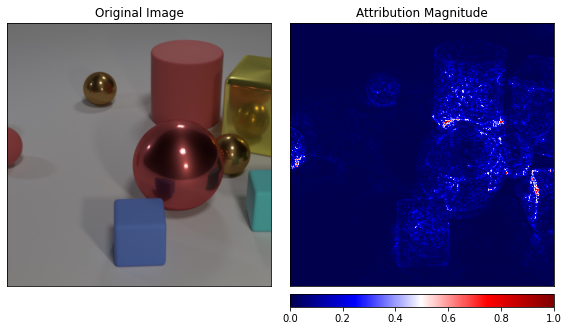

Text Contributions:  12.65450101030455
Image Contributions:  6.207770199042872
Total Contribution:  18.862271209347423


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
on wall,on wall (0.12),on the right,13.06,where is the golden cube


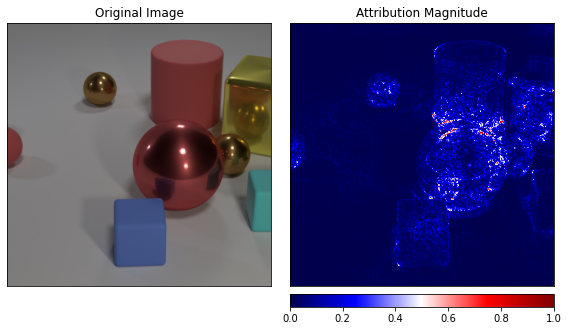

Text Contributions:  13.055591008146285
Image Contributions:  6.197489896122815
Total Contribution:  19.2530809042691


In [ ]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 3 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is large sphere",
    "where is the golden cube"
], ['objects', 'red', 'on the right'])